In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
import networkx as nx
from collections import defaultdict
import folium

In [ ]:
#Loading the uploaded files
file_wlwwar = r"data/ebd_wlwwar_relOct-2025.txt"
#file_rthhum = r"Climate-Change-Driven-Bird-Migration\data\ebd_rthhum_smp_relOct-2025\ebd_rthhum_smp_relOct-2025.txt"
#file_swathr = r"Climate-Change-Driven-Bird-Migration\data\ebd_swathr_relOct-2025\ebd_swathr_relOct-2025.txt"

cols = ["GLOBAL UNIQUE IDENTIFIER", "OBSERVATION DATE", "COMMON NAME", "OBSERVATION COUNT", "COUNTRY", "STATE", "COUNTY", "LOCALITY", "LATITUDE", "LONGITUDE"]
#chunks = pd.read_csv(file_bkpwar, sep="\t", low_memory = True, chunksize = 100000)
df_wl = pd.read_csv(file_wlwwar, sep = "\t", low_memory = True, usecols = cols )
#f_rt = pd.read_csv(file_rthhum)
#f_sw = pd.read_csv(file_swathr)


#Checking for null values in data
print(f"Null values df_wl: \n{df_wl.isna().sum()}")
#print(f"\nNull values df_rt: \n{df_rt.isnull().sum()}")
#print(f"\nNull values df_sw: \n{df_sw.isnull().sum()}")

Null values df_bk: 
GLOBAL UNIQUE IDENTIFIER         0
COMMON NAME                      0
OBSERVATION COUNT                0
COUNTRY                          0
STATE                            0
COUNTY                      364247
LOCALITY                         1
LATITUDE                         0
LONGITUDE                        0
OBSERVATION DATE                 0
dtype: int64


In [3]:
df_wl["OBSERVATION DATE"] = pd.to_datetime(df_wl["OBSERVATION DATE"])
df_wl = df_wl.sort_values(by="OBSERVATION DATE", ascending=False).reset_index(drop = True)

In [4]:
df_wl.head(100)

,GLOBAL UNIQUE IDENTIFIER,COMMON NAME,OBSERVATION COUNT,COUNTRY,STATE,COUNTY,LOCALITY,LATITUDE,LONGITUDE,OBSERVATION DATE
0,URN:CornellLabOfOrnithology:EBIRD:OBS3713366292,Willow Warbler,1,Israel,HaZafon,NaN,kfar HaNassi כפר הנשיא,32.974720,35.602190,2025-10-31
1,URN:CornellLabOfOrnithology:EBIRD:OBS3717709714,Willow Warbler,1,Zimbabwe,Bulawayo,NaN,harry allen,-20.158449,28.625664,2025-10-31
2,URN:CornellLabOfOrnithology:EBIRD:OBS3712937447,Willow Warbler,1,Ghana,Northern,NaN,Mole Hotel - Without Waterhole,9.260567,-1.855697,2025-10-31
3,URN:CornellLabOfOrnithology:EBIRD:OBS3713407837,Willow Warbler,1,Greece,Attica,Piraeus,Πάρκο ΣΕΦ (Peace and Friendship Stadium Park),37.941706,23.664441,2025-10-31
4,URN:CornellLabOfOrnithology:EBIRD:OBS3712729538,Willow Warbler,1,Zambia,Southern,NaN,BHL New Clipper Road,-17.784183,25.617712,2025-10-31
...,...,...,...,...,...,...,...,...,...,...
95,URN:CornellLabOfOrnithology:EBIRD:OBS3714253298,Willow Warbler,1,Portugal,Setúbal,Moita,Sapal de Alhos Vedros,38.664654,-9.021406,2025-10-30
96,URN:CornellLabOfOrnithology:EBIRD:OBS3710256840,Willow Warbler,1,France,Provence-Alpes-Côte d'Azur,Bouches-du-Rhône,"Route de la Mer, Arles FR-Provence-Alpes-Côte ...",43.382081,4.800781,2025-10-30
97,URN:CornellLabOfOrnithology:EBIRD:OBS3709202729,Willow Warbler,1,Israel,HaDarom,NaN,"מסור, ספיר, מחוז הדרום, IL (30.613, 35.181)",30.613138,35.181201,2025-10-30
98,URN:CornellLabOfOrnithology:EBIRD:OBS3710062187,Willow Warbler,1,Spain,Andalucía,Cádiz,Laguna de Medina,36.613013,-6.056750,2025-10-30


In [5]:
df_wl.drop(columns=["COUNTY"], inplace=True)

In [6]:
df_wl.dropna(inplace=True)

In [7]:
len(df_wl["LOCALITY"].unique())

176434

In [8]:
#replace observation count values "X" (an observation was made but the exact number of birds was not counted), we replace with 1
df_wl["OBSERVATION COUNT"].replace(to_replace="X", value=1, inplace=True)

/var/folders/gr/pjdyrzt14_bbr3sfzt7zjf6h0000gn/T/ipykernel_14207/1864905683.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_wl["OBSERVATION COUNT"].replace(to_replace="X", value=1, inplace=True)


In [9]:
df_wl["OBSERVATION COUNT"] = pd.to_numeric(df_wl["OBSERVATION COUNT"], errors='coerce')

In [ ]:
total_birds_wl = df_wl["OBSERVATION COUNT"].sum()

print("Total birds observed", total_birds_wl)

Total birds observed 2442519


## DBSCAN Clustering And Network Creation

In [11]:
def filter_recent_decade(df, years=10):
    """Filter to most recent decade of data"""
    max_date = df["OBSERVATION DATE"].max()
    cutoff_date = max_date - pd.DateOffset(years=years)
    return df[df["OBSERVATION DATE"] >= cutoff_date].copy()

df_recent = filter_recent_decade(df_wl, years=10)
print(f"Data after filtering to recent decade: {len(df_recent):,} records")
print(f"Date range: {df_recent['OBSERVATION DATE'].min()} to {df_recent['OBSERVATION DATE'].max()}")

# OPTION 2: Aggregate observations spatially and temporally
def optimized_dbscan_clustering(df, eps_km=25, min_samples=3, batch_size=50000):
    """
    Memory-optimized DBSCAN clustering for large datasets
    """
    print(f"Clustering {len(df):,} points with optimized DBSCAN...")
    
    # Step 1: Pre-filter - aggregate nearby points first
    print("Pre-filtering: Aggregating very close points...")
    
    # Round coordinates to reduce unique points (0.01 degree ~ 1.1 km)
    precision = 0.01  # ~1.1 km precision
    df['lat_rounded'] = (df['LATITUDE'] / precision).round() * precision
    df['lon_rounded'] = (df['LONGITUDE'] / precision).round() * precision
    
    # Group by rounded coordinates
    agg_points = df.groupby(['lat_rounded', 'lon_rounded']).agg({
        'LATITUDE': 'mean',
        'LONGITUDE': 'mean',
        'OBSERVATION COUNT': 'sum',
        'STATE': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
    }).reset_index()
    
    print(f"Reduced from {len(df):,} to {len(agg_points):,} unique points")
    
    # Step 2: Use cKDTree for faster neighbor searches
    print("Building KD-Tree for fast neighbor queries...")
    coords = agg_points[['LATITUDE', 'LONGITUDE']].values
    
    # Convert epsilon from km to radians
    # 1 degree = ~111 km, so eps_km/111 gives degrees
    eps_deg = eps_km / 111
    
    # Use custom DBSCAN implementation with KD-Tree
    def custom_dbscan_kdtree(points, eps, min_samples):
        """Custom DBSCAN using KD-Tree for memory efficiency"""
        tree = cKDTree(points)
        n_samples = len(points)
        
        # Find neighbors within epsilon
        neighbors = tree.query_ball_point(points, eps, workers=-1)
        
        labels = np.full(n_samples, -1, dtype=np.int32)
        cluster_id = 0
        
        for i in range(n_samples):
            if labels[i] != -1:
                continue
                
            if len(neighbors[i]) < min_samples:
                labels[i] = -1  # Noise
                continue
                
            # Start new cluster
            labels[i] = cluster_id
                
            # Expand cluster
            seeds = set(neighbors[i])
            seeds.discard(i)
            
            while seeds:
                j = seeds.pop()
                
                if labels[j] == -1:  # Noise becomes border point
                    labels[j] = cluster_id
                    
                if labels[j] != -1:  # Already assigned
                    continue
                    
                labels[j] = cluster_id
                
                if len(neighbors[j]) >= min_samples:
                    seeds.update(neighbors[j])
            
            cluster_id += 1
        
        return labels
    
    # Apply custom DBSCAN in batches if still too large
    if len(agg_points) > 100000:
        print("Applying batched DBSCAN...")
        
        # Split into geographic regions
        min_lat, max_lat = coords[:, 0].min(), coords[:, 0].max()
        min_lon, max_lon = coords[:, 1].min(), coords[:, 1].max()
        
        # Create overlapping regions to avoid edge effects
        lat_step = (max_lat - min_lat) / 3
        lon_step = (max_lon - min_lon) / 3
        
        all_labels = np.full(len(agg_points), -1, dtype=np.int32)
        cluster_offset = 0
        
        for i in range(3):
            for j in range(3):
                # Create region with overlap
                lat_min = min_lat + i * lat_step - eps_deg
                lat_max = min_lat + (i + 1) * lat_step + eps_deg
                lon_min = min_lon + j * lon_step - eps_deg
                lon_max = min_lon + (j + 1) * lon_step + eps_deg
                
                region_mask = ((coords[:, 0] >= lat_min) & (coords[:, 0] <= lat_max) &
                              (coords[:, 1] >= lon_min) & (coords[:, 1] <= lon_max))
                
                if region_mask.sum() == 0:
                    continue
                    
                region_points = coords[region_mask]
                
                # Cluster this region
                region_labels = custom_dbscan_kdtree(region_points, eps_deg, min_samples)
                
                # Adjust cluster IDs and assign
                region_labels[region_labels != -1] += cluster_offset
                all_labels[region_mask] = region_labels
                
                # Update offset
                if len(region_labels[region_labels != -1]) > 0:
                    cluster_offset = region_labels.max() + 1
        
        agg_points['cluster_id'] = all_labels
    else:
        # Direct clustering
        print("Clustering all points at once...")
        labels = custom_dbscan_kdtree(coords, eps_deg, min_samples)
        agg_points['cluster_id'] = labels
    
    # Step 3: Map original points to clusters
    print("Mapping original points to clusters...")
    
    # Create KD-Tree for cluster centroids
    clustered = agg_points[agg_points['cluster_id'] != -1]
    if len(clustered) == 0:
        print("No clusters found!")
        return df.assign(cluster_id=-1), pd.DataFrame()
    
    # Find nearest cluster for each original point
    cluster_coords = clustered[['LATITUDE', 'LONGITUDE']].values
    cluster_tree = cKDTree(cluster_coords)
    
    # Query nearest cluster for each original point
    original_coords = df[['LATITUDE', 'LONGITUDE']].values
    distances, indices = cluster_tree.query(original_coords, k=1, workers=-1)
    
    # Map cluster IDs
    cluster_ids = clustered['cluster_id'].values
    df['cluster_id'] = cluster_ids[indices]
    
    # Points too far from any cluster become noise
    max_dist_deg = eps_deg * 2  # Allow some flexibility
    df.loc[distances > max_dist_deg, 'cluster_id'] = -1
    
    # Create cluster summaries
    print("Creating cluster summaries...")
    cluster_summary = []
    for cluster_id in np.unique(df['cluster_id']):
        if cluster_id == -1:
            continue
            
        cluster_points = df[df['cluster_id'] == cluster_id]
        
        # Calculate weighted centroid
        if 'OBSERVATION COUNT' in cluster_points.columns:
            weights = cluster_points['OBSERVATION COUNT'].fillna(1).values
            centroid_lat = np.average(cluster_points['LATITUDE'].values, weights=weights)
            centroid_lon = np.average(cluster_points['LONGITUDE'].values, weights=weights)
        else:
            centroid_lat = cluster_points['LATITUDE'].mean()
            centroid_lon = cluster_points['LONGITUDE'].mean()
        
        cluster_summary.append({
            'cluster_id': int(cluster_id),
            'centroid_lat': centroid_lat,
            'centroid_lon': centroid_lon,
            'n_observations': len(cluster_points),
            'total_birds': cluster_points['OBSERVATION COUNT'].sum(),
            'first_seen': cluster_points['OBSERVATION DATE'].min(),
            'last_seen': cluster_points['OBSERVATION DATE'].max(),
            'state': cluster_points['STATE'].mode().iloc[0] if not cluster_points['STATE'].mode().empty else 'Unknown',
            'area_km2': len(cluster_points) * 3.14 * (eps_km/2)**2  # Approximate area
        })
    
    cluster_df = pd.DataFrame(cluster_summary)
    print(f"Found {len(cluster_df)} clusters")
    
    return df, cluster_df

# Apply optimized DBSCAN
df_clustered, cluster_nodes = optimized_dbscan_clustering(df_recent, eps_km=20, min_samples=5)

# Create migration edges based on temporal sequence
def create_migration_edges(df_clustered, cluster_nodes, max_days=90):
    """
    Create directed edges between clusters based on temporal migration patterns
    max_days: maximum days between observations to consider as migration
    """
    edges = defaultdict(lambda: defaultdict(int))
    edge_details = []
    
    # Group by year to track annual migration patterns
    df_clustered['year'] = df_clustered['OBSERVATION DATE'].dt.year
    df_clustered['yearday'] = df_clustered['OBSERVATION DATE'].dt.dayofyear
    
    # For each year, create edges based on temporal sequence
    for year in df_clustered['year'].unique():
        year_data = df_clustered[df_clustered['year'] == year]
        
        # Sort by date within the year
        year_data = year_data.sort_values('yearday')
        
        # Get unique clusters visited in this year (in temporal order)
        clusters_visited = year_data.drop_duplicates('cluster_id', keep='first')
        clusters_visited = clusters_visited[clusters_visited['cluster_id'] != -1]
        
        # Create edges between consecutive clusters
        for i in range(len(clusters_visited) - 1):
            source = clusters_visited.iloc[i]
            target = clusters_visited.iloc[i + 1]
            
            # Only create edge if within reasonable migration time window
            days_diff = abs(source['yearday'] - target['yearday'])
            if 1 <= days_diff <= max_days:  # At least 1 day, at most max_days
                edge_key = (int(source['cluster_id']), int(target['cluster_id']))
                edges[edge_key]['weight'] += 1
                edges[edge_key]['total_birds'] = edges[edge_key].get('total_birds', 0) + \
                                                  source['OBSERVATION COUNT'] + target['OBSERVATION COUNT']
                edges[edge_key]['years'] = edges[edge_key].get('years', set())
                edges[edge_key]['years'].add(year)
                
                edge_details.append({
                    'source': int(source['cluster_id']),
                    'target': int(target['cluster_id']),
                    'year': year,
                    'source_date': source['OBSERVATION DATE'],
                    'target_date': target['OBSERVATION DATE'],
                    'days_between': days_diff
                })
    
    # Convert to edge list
    edge_list = []
    for (source, target), data in edges.items():
        edge_list.append({
            'source': source,
            'target': target,
            'weight': data['weight'],
            'total_birds': data['total_birds'],
            'n_years': len(data['years']),
            'years': list(data['years'])
        })
    
    return pd.DataFrame(edge_list), pd.DataFrame(edge_details)

# Create migration edges
edges_df, edge_details_df = create_migration_edges(df_clustered, cluster_nodes, max_days=60)
print(f"Created {len(edges_df)} migration edges")

# Create network graph
def create_migration_network(cluster_nodes, edges_df):
    """Create a directed weighted graph from clusters and edges"""
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, node in cluster_nodes.iterrows():
        G.add_node(node['cluster_id'],
                   lat=node['centroid_lat'],
                   lon=node['centroid_lon'],
                   n_observations=node['n_observations'],
                   total_birds=node['total_birds'],
                   state=node['state'],
                   label=f"Cluster {int(node['cluster_id'])}")
    
    # Add edges with weights
    for _, edge in edges_df.iterrows():
        G.add_edge(edge['source'], edge['target'],
                   weight=edge['weight'],
                   total_birds=edge['total_birds'],
                   n_years=edge['n_years'])
    
    return G

# Build the network
G = create_migration_network(cluster_nodes, edges_df)
print(f"Network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Calculate network metrics
def calculate_network_metrics(G):
    """Calculate important network metrics for migration analysis"""
    metrics = {}
    
    # Basic metrics
    metrics['n_nodes'] = G.number_of_nodes()
    metrics['n_edges'] = G.number_of_edges()
    metrics['density'] = nx.density(G)
    
    # Degree centrality
    in_degree = dict(G.in_degree(weight='weight'))
    out_degree = dict(G.out_degree(weight='weight'))
    
    # Identify key nodes (stopover sites)
    key_nodes = []
    for node in G.nodes():
        node_data = G.nodes[node]
        key_nodes.append({
            'cluster_id': node,
            'in_degree': in_degree.get(node, 0),
            'out_degree': out_degree.get(node, 0),
            'total_degree': in_degree.get(node, 0) + out_degree.get(node, 0),
            'n_observations': node_data['n_observations'],
            'lat': node_data['lat'],
            'lon': node_data['lon'],
            'state': node_data['state']
        })
    
    key_nodes_df = pd.DataFrame(key_nodes).sort_values('total_degree', ascending=False)
    
    # Identify major migration corridors
    edge_weights = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]
    edge_weights.sort(key=lambda x: x[2], reverse=True)
    
    return metrics, key_nodes_df, edge_weights[:10]  # Top 10 edges

# Get metrics
metrics, key_nodes_df, top_edges = calculate_network_metrics(G)

print("\n=== Network Metrics ===")
for key, value in metrics.items():
    print(f"{key}: {value}")

print("\n=== Top 10 Stopover Sites ===")
print(key_nodes_df.head(10)[['cluster_id', 'state', 'total_degree', 'n_observations']])

print("\n=== Top 10 Migration Corridors ===")
for u, v, w in top_edges:
    u_state = G.nodes[u]['state']
    v_state = G.nodes[v]['state']
    print(f"Cluster {u} ({u_state}) -> Cluster {v} ({v_state}): weight={w}")

# Visualization functions
def plot_network_graph(G, key_nodes_df, top_n=20):
    """Plot network visualization"""
    plt.figure(figsize=(14, 10))
    
    # Use node positions based on geography (simplified)
    pos = {node: (G.nodes[node]['lon'], G.nodes[node]['lat']) for node in G.nodes()}
    
    # Node sizes based on degree
    node_sizes = [key_nodes_df[key_nodes_df['cluster_id'] == node]['total_degree'].values[0] * 50 
                  if node in key_nodes_df['cluster_id'].values else 30 
                  for node in G.nodes()]
    
    # Edge widths based on weight
    edge_widths = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
    
    # Draw network
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                          node_color='lightblue', alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_widths, 
                          edge_color='gray', alpha=0.5, 
                          arrows=True, arrowsize=10)
    
    # Label only important nodes
    important_nodes = key_nodes_df.head(top_n)['cluster_id'].values
    labels = {node: f"{node}\n{G.nodes[node]['state']}" 
              for node in G.nodes() if node in important_nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title(f"Bird Migration Network\n{len(G.nodes())} stopover sites, {len(G.edges())} migration routes")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_interactive_map(G, key_nodes_df):
    """Create interactive folium map of migration network"""
    # Calculate center of map
    center_lat = key_nodes_df['lat'].mean()
    center_lon = key_nodes_df['lon'].mean()
    
    m = folium.Map(location=[center_lat, center_lon], zoom_start=4)
    
    # Add nodes
    for _, node in key_nodes_df.iterrows():
        popup_text = f"""
        <b>Cluster {int(node['cluster_id'])}</b><br>
        State: {node['state']}<br>
        Total Degree: {node['total_degree']}<br>
        Observations: {int(node['n_observations']):,}<br>
        In Degree: {node['in_degree']}<br>
        Out Degree: {node['out_degree']}
        """
        
        folium.CircleMarker(
            location=[node['lat'], node['lon']],
            radius=np.log(node['total_degree'] + 1) * 3,
            popup=popup_text,
            color='blue',
            fill=True,
            fill_opacity=0.6
        ).add_to(m)
    
    # Add edges (migration routes)
    for u, v, data in G.edges(data=True):
        u_lat, u_lon = G.nodes[u]['lat'], G.nodes[u]['lon']
        v_lat, v_lon = G.nodes[v]['lat'], G.nodes[v]['lon']
        
        # Only plot significant edges
        if data['weight'] > 1:
            folium.PolyLine(
                locations=[[u_lat, u_lon], [v_lat, v_lon]],
                weight=data['weight'] * 0.5,
                color='red',
                opacity=0.5,
                popup=f"Migration route<br>Weight: {data['weight']}<br>Years: {data['n_years']}"
            ).add_to(m)
    
    return m

# Generate visualizations
print("\nGenerating visualizations...")



Data after filtering to recent decade: 663,751 records
Date range: 2015-10-31 00:00:00 to 2025-10-31 00:00:00
Clustering 663,751 points with optimized DBSCAN...
Pre-filtering: Aggregating very close points...
Reduced from 663,751 to 121,983 unique points
Building KD-Tree for fast neighbor queries...
Applying batched DBSCAN...
Mapping original points to clusters...
Creating cluster summaries...
Found 9617 clusters
Created 3408 migration edges
Network created with 9617 nodes and 3408 edges

=== Network Metrics ===
n_nodes: 9617
n_edges: 3408
density: 3.685237785210155e-05

=== Top 10 Stopover Sites ===
     cluster_id               state  total_degree  n_observations
517         517             Central            10             384
508         508              Nyanza            10              82
241         241              Sofala            10              72
48           48       Kwazulu-Natal             9              59
78           78             Gauteng             9             

## Network Visualization and Analysis

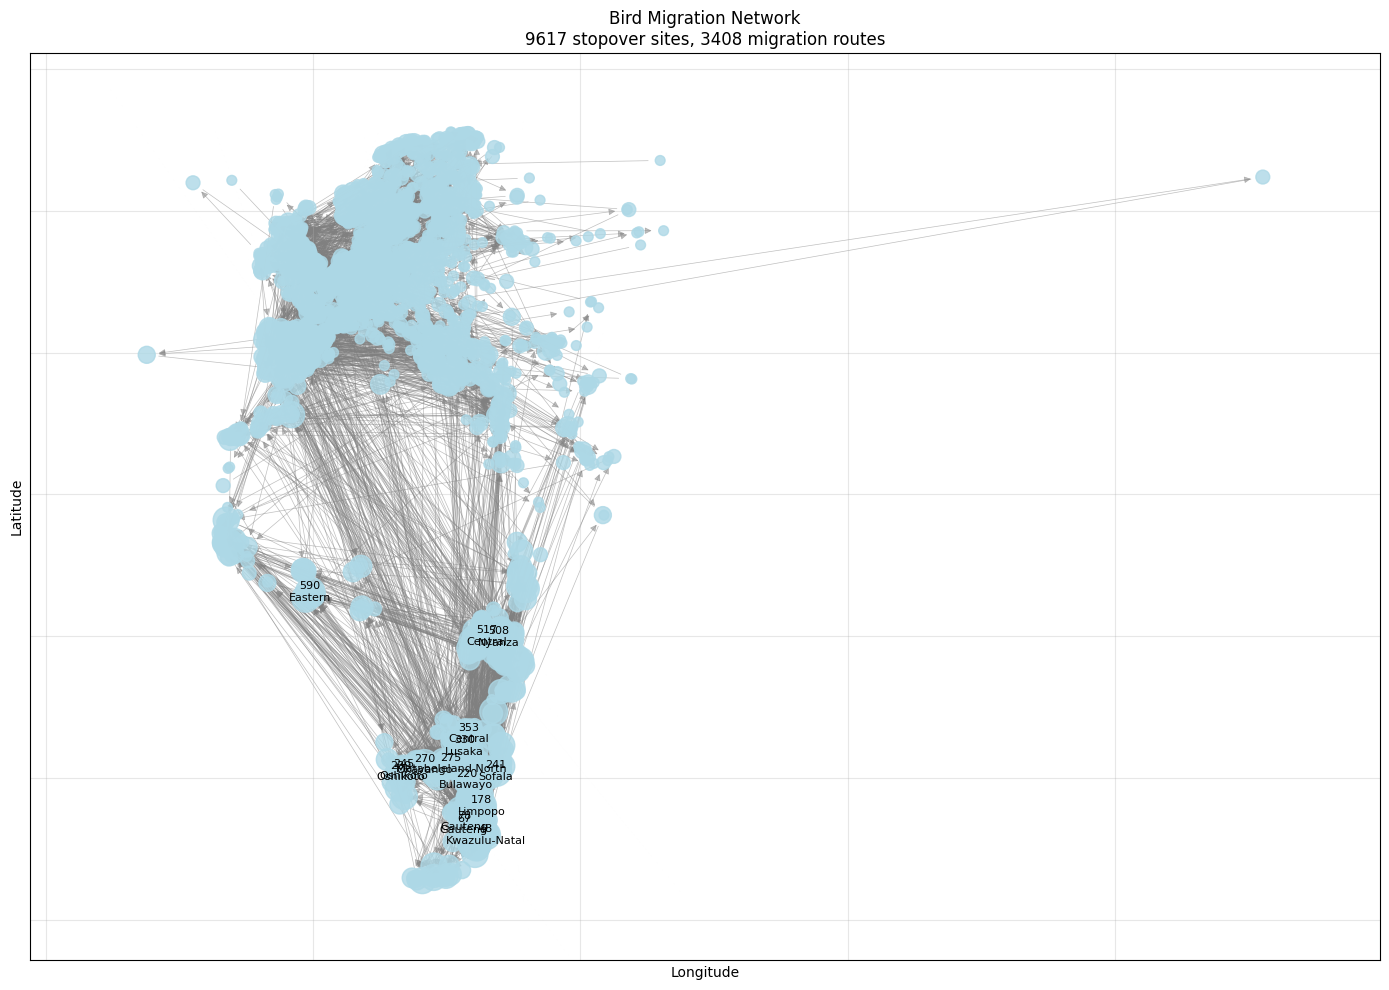

Interactive map saved to 'migration_network.html'


/var/folders/gr/pjdyrzt14_bbr3sfzt7zjf6h0000gn/T/ipykernel_14207/1591597972.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustered['year'] = df_clustered['OBSERVATION DATE'].dt.year
/var/folders/gr/pjdyrzt14_bbr3sfzt7zjf6h0000gn/T/ipykernel_14207/1591597972.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustered['yearday'] = df_clustered['OBSERVATION DATE'].dt.dayofyear
/var/folders/gr/pjdyrzt14_bbr3sfzt7zjf6h0000gn/T/ipykernel_14207/1591597972.py:211: SettingWithCopyWarning: 
A value


=== Temporal Changes in Migration Patterns ===
  year_window  n_observations  n_clusters_visited  n_migration_edges  \
0   2015-2019          114358                7062               1406   
1   2020-2024          415456                9298               1702   
2   2025-2029          133937                7936                301   

   avg_edge_weight  
0         1.000711  
1         1.000000  
2         1.000000  


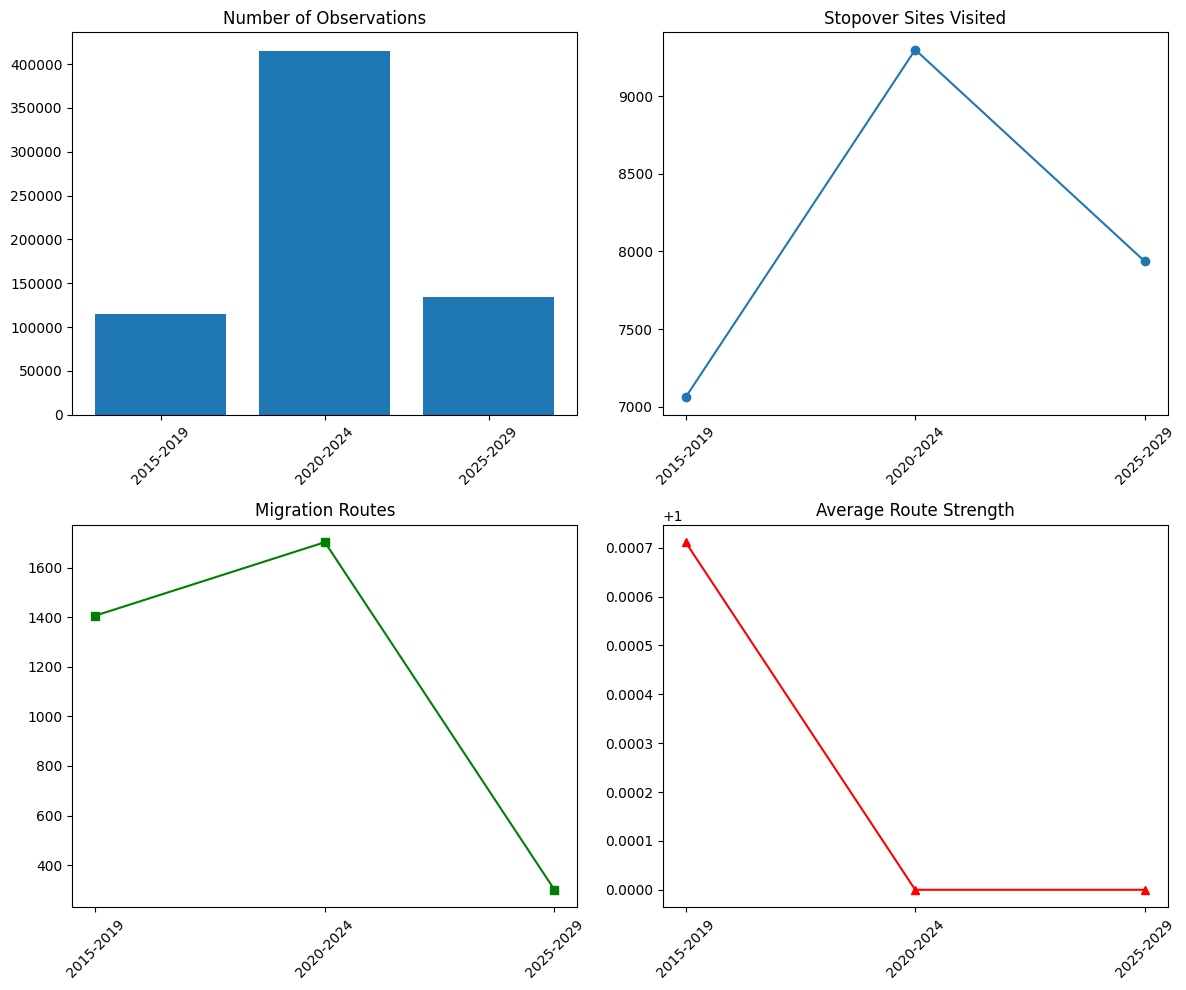


Exporting data for external visualization tools...
Data exported to 'migration_nodes.csv' and 'migration_edges.csv'

=== Analysis Complete ===


In [12]:
# Plot static network
plot_network_graph(G, key_nodes_df, top_n=15)

# Create interactive map (save to HTML)
interactive_map = create_interactive_map(G, key_nodes_df)
interactive_map.save("migration_network.html")
print("Interactive map saved to 'migration_network.html'")

# Analyze temporal changes in migration
def analyze_temporal_changes(df_clustered, cluster_nodes, year_window=5):
    """Analyze how migration patterns change over time"""
    
    # Group by time windows
    df_clustered['year_window'] = (df_clustered['year'] // year_window) * year_window
    
    temporal_analysis = []
    
    for window in sorted(df_clustered['year_window'].unique()):
        window_data = df_clustered[df_clustered['year_window'] == window]
        
        if len(window_data) < 10:  # Skip windows with insufficient data
            continue
            
        # Create edges for this time window
        edges_window, _ = create_migration_edges(window_data, cluster_nodes, max_days=60)
        
        temporal_analysis.append({
            'year_window': f"{window}-{window+year_window-1}",
            'n_observations': len(window_data),
            'n_clusters_visited': len(window_data['cluster_id'].unique()) - 1,  # Exclude -1
            'n_migration_edges': len(edges_window),
            'avg_edge_weight': edges_window['weight'].mean() if len(edges_window) > 0 else 0
        })
    
    return pd.DataFrame(temporal_analysis)

# Analyze temporal changes
temporal_changes = analyze_temporal_changes(df_clustered, cluster_nodes, year_window=5)

print("\n=== Temporal Changes in Migration Patterns ===")
print(temporal_changes)

# Plot temporal trends
if len(temporal_changes) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Observations over time
    axes[0, 0].bar(temporal_changes['year_window'], temporal_changes['n_observations'])
    axes[0, 0].set_title('Number of Observations')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Clusters visited
    axes[0, 1].plot(temporal_changes['year_window'], temporal_changes['n_clusters_visited'], marker='o')
    axes[0, 1].set_title('Stopover Sites Visited')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Migration edges
    axes[1, 0].plot(temporal_changes['year_window'], temporal_changes['n_migration_edges'], marker='s', color='green')
    axes[1, 0].set_title('Migration Routes')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Average edge weight
    axes[1, 1].plot(temporal_changes['year_window'], temporal_changes['avg_edge_weight'], marker='^', color='red')
    axes[1, 1].set_title('Average Route Strength')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Export data for further analysis
print("\nExporting data for external visualization tools...")

# Export node and edge lists for Gephi or other network tools
nodes_export = key_nodes_df.copy()
nodes_export['Id'] = nodes_export['cluster_id']
nodes_export['Label'] = nodes_export['state']
nodes_export[['Id', 'Label', 'lat', 'lon', 'total_degree', 'n_observations']].to_csv('migration_nodes.csv', index=False)

edges_export = edges_df.copy()
edges_export['Source'] = edges_export['source']
edges_export['Target'] = edges_export['target']
edges_export['Type'] = 'Directed'
edges_export['Weight'] = edges_export['weight']
edges_export[['Source', 'Target', 'Type', 'Weight', 'n_years']].to_csv('migration_edges.csv', index=False)

print("Data exported to 'migration_nodes.csv' and 'migration_edges.csv'")
print("\n=== Analysis Complete ===")